## 概要
- Poseを使った異常検知をMNISTでテストしてみる

In [ ]:
! apt-get install -y fonts-takao-gothic
! echo "\nfont.family: TakaoPGothic" >> $(python -c 'import matplotlib as m; print(m.matplotlib_fname())')
! rm -f ~/.cache/matplotlib/font*

## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from keras.datasets import mnist
from keras.layers import Input, Dense, Layer, BatchNormalization, Dropout
from keras.layers import Lambda, Conv2D, Flatten, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model, model_from_json
from keras import backend as K
#from keras import objectives
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
from scipy.stats import norm
from sklearn.model_selection import train_test_split

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
K.tensorflow_backend.set_session(session)

from glob import glob
from multiprocessing import Pool
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from time import time
import datetime
import os
from collections import OrderedDict


Bad key "\nfont.family" on line 618 in
/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

## モデルの読み込み

In [3]:
# アーキテクチャの読み込み
with open("../output/conv_vae_model_20190107_074233.json") as f:
    json_string = f.readline()

In [4]:
vae = model_from_json(json_string)
vae.load_weights("../output/conv_vae_best_param_20190107_074233.hdf5")

## データの読み込み(1局分)

In [5]:
!ls /media/nvidia/JetsonTX2SSD240/data/shogi_pose_dataset/

AbemaTV_Tournament_Final1			fujii_vs_kondo_Ablock_1_1080p
AbemaTV_Tournament_final1_abnorm_supervised	fujii_vs_kondo_Ablock_2_1_1080p
AbemaTV_Tournament_final1_abnorm_supervised_v2	fujii_vs_kondo_Ablock_2_2_1080p
AbemaTV_Tournament_Final2			fujii_vs_takami_semi_1_1080p
AbemaTV_Tournament_Final3			fujii_vs_takami_semi_2_1080p
final1_labeling					fujii_vs_takami_semi_3_1080p


In [6]:
!ls ../data/shogi_pose_dataset/

AbemaTV_Tournament_Final1	 fujii_vs_kondo_Ablock_2_2_1080p
AbemaTV_Tournament_Final2	 fujii_vs_takami_semi_1_1080p
AbemaTV_Tournament_Final3	 fujii_vs_takami_semi_2_1080p
fujii_vs_kondo_Ablock_1_1080p	 fujii_vs_takami_semi_3_1080p
fujii_vs_kondo_Ablock_2_1_1080p


In [22]:
data_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final1/*"))
#data_path = sorted(glob("/media/nvidia/JetsonTX2SSD240/data/shogi_pose_dataset/AbemaTV_Tournament_Final1/*"))[::2]

In [23]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    idx = int(path[-10:-4])
    size = 32
    
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 150) or (width < 150):
            return {idx: np.zeros((size, size))}
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return {idx: img_bin * 255.0}
    except:
        return {idx: np.zeros((size, size))}

In [24]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [10]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    idx = int(path[-10:-4])
    return {idx: img * 255.0}

In [25]:
imgs_dict = {}
with tqdm(total=len(data_path)) as pbar:
    with Pool(mp.cpu_count()) as p:
        for img in tqdm(p.imap_unordered(read_img, data_path)):
            imgs_dict.update(img)
            pbar.update()
imgs_dict = OrderedDict(sorted(imgs_dict.items(), key=lambda x: x[0]))

In [26]:
imgs = np.array([item[1].astype(np.float32) for item in imgs_dict.items()])

In [27]:
black_idxs = np.where(imgs.mean(axis=(1,2)) == 0)[0]

In [28]:
white_idxs = np.where(imgs.mean(axis=(1,2)) != 0)[0]

In [29]:
imgs /= 255 
#imgs = imgs[np.where(imgs.mean(axis=(1,2)) != 0)[0]]

In [30]:
imgs.shape

(10322, 32, 32)

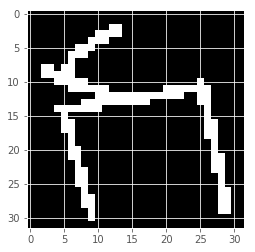

In [31]:
plt.imshow(imgs[0], cmap="gray")

In [32]:
imgs_num, height, width = imgs.shape

imgs = imgs.reshape(imgs_num, height, width, 1)

print(imgs.shape)

(10322, 32, 32, 1)


## モデルによる生成

In [46]:
img_pred = vae.predict(imgs.astype(np.float32))
#img_pred = vae.predict(imgs.astype(np.uint8))

(-0.5, 31.5, 31.5, -0.5)

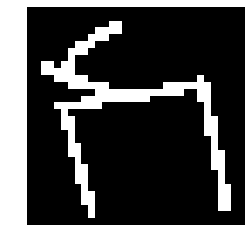

In [47]:
plt.imshow(imgs[0].reshape(32,32), cmap="gray")
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

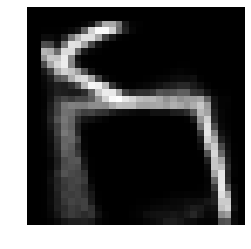

In [65]:
plt.imshow((img_pred.astype(np.float32))[0].reshape(32,32), cmap="gray")
plt.axis("off")

In [66]:
img_pred[0].mean()

0.11911118

In [60]:
(img_pred[0] * 255).mean()

30.37335

## 異常検知に使用するしきい値の決定

In [49]:
import pandas as pd

In [67]:
l = []
for y_true, y_pred in tqdm(zip(imgs.astype(np.float32), img_pred.astype(np.float32))):
    y_diff = y_true.reshape(32,32) - y_pred.reshape(32,32)
    l.append(np.sum(np.abs(y_diff)))
df = pd.DataFrame(l, columns=["pixel_diff"])

In [91]:
# df["pixel_diff"] = df["pixel_diff"].map(lambda x: np.nan if x < 1 else x).fillna(method="ffill")
# scores_df = df
scores_df = df.iloc[white_idxs, :]

In [92]:
scores_df.shape

(9721, 3)

Text(0.5, 0, 'images difference (pixel base)')

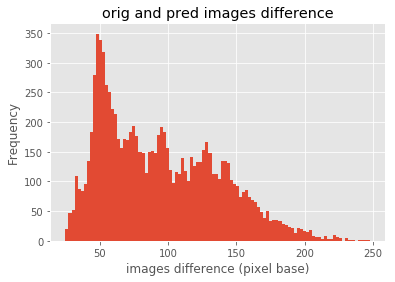

In [93]:
fig, ax = plt.subplots()

ax = scores_df["pixel_diff"].plot.hist(bins=100)
ax.set_title("orig and pred images difference")
ax.set_xlabel("images difference (pixel base)")

## Phashで比較

In [94]:
import imagehash
from PIL import Image

In [95]:
l = []
for y_true, y_pred in tqdm(zip(imgs, img_pred)):
    true_hash = imagehash.phash(Image.fromarray(np.uint8(y_true * 255).reshape(32,32)))
    pred_hash = imagehash.phash(Image.fromarray((y_pred * 255).astype(np.uint8).reshape(32,32)))
    y_diff = true_hash - pred_hash
    l.append(y_diff)

In [96]:
_df = pd.DataFrame(l, columns=["phash_diff"])

In [97]:
scores_df["phash_diff"] = _df.iloc[white_idxs, :]

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'images difference (phash base)')

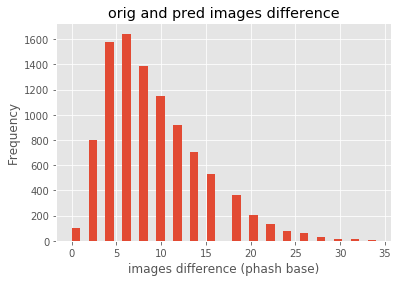

In [98]:
fig, ax = plt.subplots()

ax = scores_df["phash_diff"].plot.hist(bins=36)
ax.set_title("orig and pred images difference")
ax.set_xlabel("images difference (phash base)")

In [99]:
len(sorted(scores_df.phash_diff.value_counts().index))

18

In [100]:
scores_df[scores_df.phash_diff == 0].index[:5]

Int64Index([1514, 1572, 2071, 2435, 2488], dtype='int64')

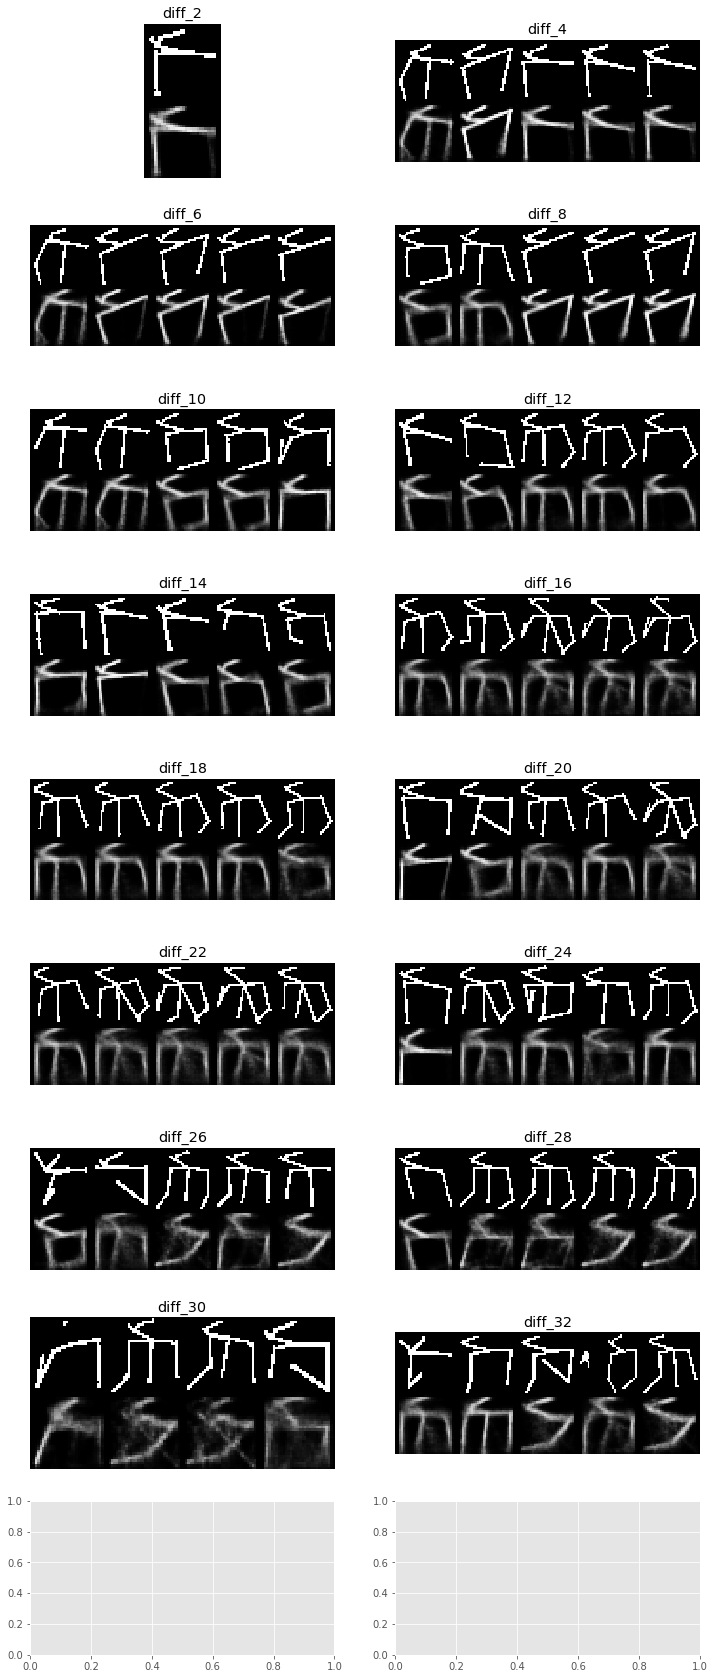

In [34]:
phash_diff = sorted(scores_df.phash_diff.value_counts().index)
fig, ax = plt.subplots(nrows=len(phash_diff)//2 + 1, ncols=2, figsize=(12,30))

compare_imgs = []
flag = True
for row, phash in enumerate(phash_diff):
    idxs = scores_df[scores_df.phash_diff == phash].index[:5]
    
    for col, idx in enumerate(idxs):
        if col == 0:
            concat_orig_img = imgs[idx].reshape(32,32)
            concat_skel_img = (img_pred * 255)[idx].reshape(32,32)
        else:
            concat_orig_img = cv2.hconcat([concat_orig_img, imgs[idx].reshape(32,32)])
            concat_skel_img = cv2.hconcat([concat_skel_img, (img_pred * 255)[idx].reshape(32,32)])
    concat_img = cv2.vconcat([concat_orig_img, concat_skel_img])
    compare_imgs.append(concat_img)
    
    if flag:
        ax[row//2, 0].imshow(concat_img, cmap="gray")
        ax[row//2, 0].set_title("diff_{}".format(phash))
        ax[row//2, 0].axis("off")
        
    else:
        ax[row//2, 1].imshow(concat_img, cmap="gray")
        ax[row//2, 1].set_title("diff_{}".format(phash))
        ax[row//2, 1].axis("off")
    flag = not flag

In [88]:
scores_df.shape

(10322, 3)

In [89]:
scores_df.phash_diff.shape

(10322,)

In [102]:
del scores_df["index"]

In [105]:
scores_df.reset_index(inplace=True)

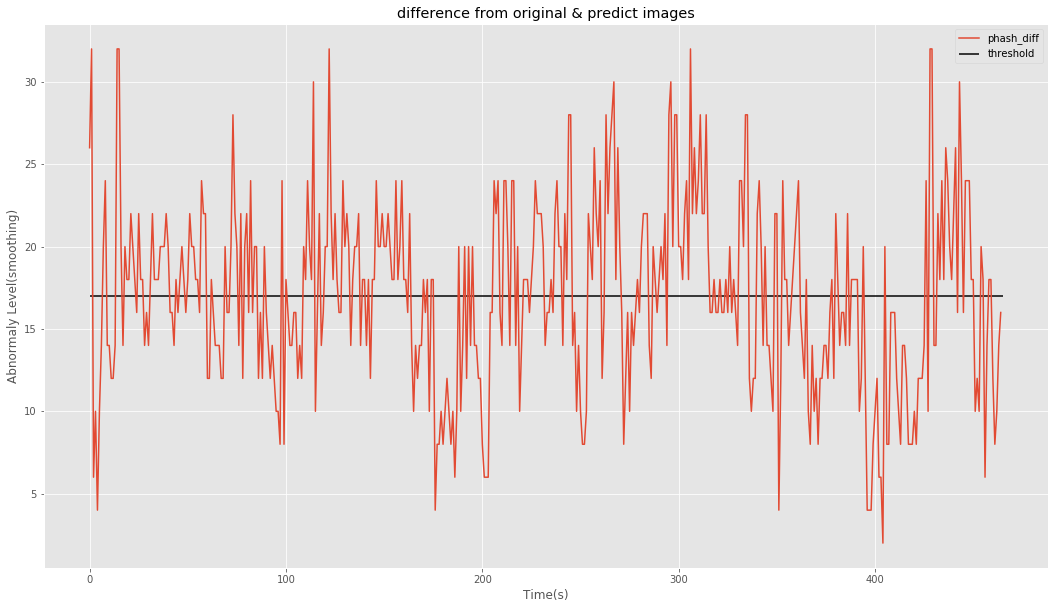

In [38]:
plt.figure(figsize=(18,10))
scores_df.phash_diff.plot()
plt.hlines(17, 0, scores_df.shape[0], label="threshold")
plt.title("difference from original & predict images")
plt.xlabel("Time(s)")
plt.ylabel("Abnormaly Level(smoothing)")
plt.legend()

In [39]:
scores_df.phash_diff.describe()

count    465.000000
mean      17.045161
std        5.609423
min        2.000000
25%       14.000000
50%       18.000000
75%       20.000000
max       32.000000
Name: phash_diff, dtype: float64

In [40]:
from scipy.interpolate import spline

In [41]:
x_smooth = np.linspace(0, scores_df.shape[0], scores_df.shape[0])
y_smooth = spline(range(scores_df.phash_diff.shape[0]), scores_df.phash_diff, x_smooth/5)

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


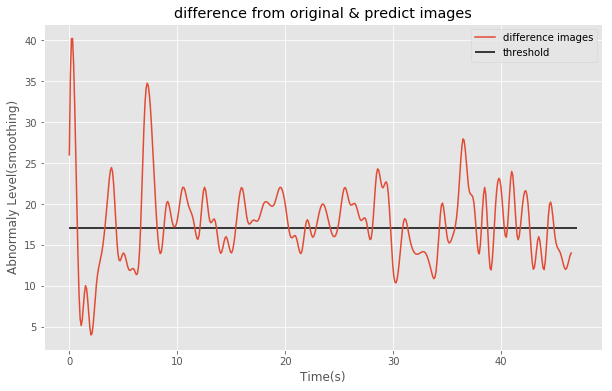

In [42]:
plt.figure(figsize=(10,6))
plt.plot(x_smooth/10, y_smooth, label="difference images")
plt.hlines(17, 0, scores_df.shape[0]//10 + 1, label="threshold")
plt.title("difference from original & predict images")
plt.xlabel("Time(s)")
plt.ylabel("Abnormaly Level(smoothing)")
plt.legend()
#plt.xticks([i * 10 for i in range(int(x_smooth.max()//100) + 1)])

In [47]:
x_smooth = np.linspace(0, scores_df.shape[0], scores_df.shape[0])
y_smooth = spline(range(scores_df.phash_diff.shape[0]), scores_df.phash_diff, x_smooth/15)

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


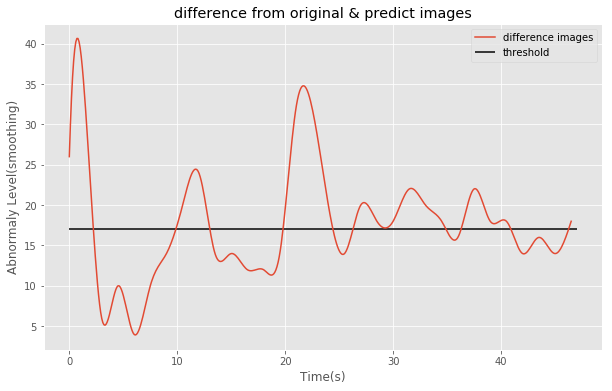

In [48]:
plt.figure(figsize=(10,6))
plt.plot(x_smooth/10, y_smooth, label="difference images")
plt.hlines(17, 0, scores_df.shape[0]//10 + 1, label="threshold")
plt.title("difference from original & predict images")
plt.xlabel("Time(s)")
plt.ylabel("Abnormaly Level(smoothing)")
plt.legend()
#plt.xticks([i * 10 for i in range(int(x_smooth.max()//100) + 1)])

### 独自ラベルに基づくprecision recall

In [106]:
from sklearn.metrics import classification_report

In [44]:
scores_df[scores_df.pixel_diff < 1].head()

,pixel_diff,phash_diff
25,0.514222,32
27,0.567476,32
28,0.549743,32
30,0.525154,32
31,0.544891,32


In [45]:
scores_df["label"] = scores_df.pixel_diff.map(lambda x: 1 if x < 1 else 0)

In [130]:
scores_df["predict"] = scores_df.phash_diff.map(lambda x: 1 if x > 17 else 0)

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
scores_df["label"] = pd.read_csv("../data/test_scores.csv").label#iloc[white_idxs, :].label
#scores_df.to_csv("../data/test_scores.csv", index=False)

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
scores_df.describe()

,index,pixel_diff,phash_diff,label,predict
count,9721.000000,9721.000000,9721.000000,9721.000000,9721.000000
mean,5106.873676,94.317152,9.120461,0.213661,0.092789
std,2970.441623,42.695459,5.497885,0.409911,0.290151
min,0.000000,24.951481,0.000000,0.000000,0.000000
25%,2519.000000,56.751709,4.000000,0.000000,0.000000
50%,5061.000000,87.785019,8.000000,0.000000,0.000000
75%,7668.000000,126.673401,12.000000,0.000000,0.000000
max,10321.000000,247.521286,34.000000,1.000000,1.000000


In [131]:
print(classification_report(scores_df.predict, scores_df.label))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      8819
           1       0.08      0.19      0.11       902

   micro avg       0.73      0.73      0.73      9721
   macro avg       0.49      0.48      0.48      9721
weighted avg       0.83      0.73      0.77      9721



## 特徴点検出による比較
- a-kaze による特徴点検出

In [64]:
akaze = cv2.AKAZE_create()

(-0.5, 31.5, 31.5, -0.5)

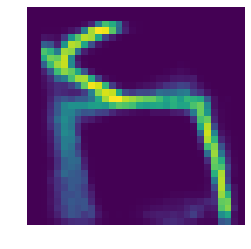

In [65]:
plt.imshow(img_pred[0].reshape(32,32))
plt.axis("off")

In [98]:
def unsharp_masking(img, i):
    img_gblur = cv2.GaussianBlur(img, (i,i), 10.0)
    unsharp_image = cv2.addWeighted(img, 1.5, img_gblur, -0.5, 0, img)
    return unsharp_image

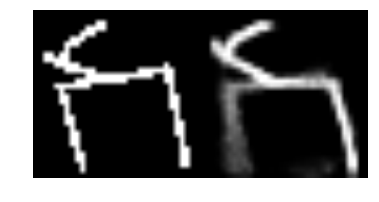

In [117]:
l = []
ratio = 0.5
size = 512
for y_true, y_pred in tqdm(zip(imgs[:1], img_pred[:1])):
    y_true = (y_true * 255).astype(np.uint8).reshape(32,32)
    y_pred = (y_pred * 255).astype(np.uint8).reshape(32,32)
    
    y_true = cv2.resize(y_true, (size, size))
    y_pred = cv2.resize(y_pred, (size, size))
    
    kp_t, des_t = akaze.detectAndCompute(y_true, None)
    kp_p, des_p = akaze.detectAndCompute(y_pred, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_t, des_p, k=2)
    matches = sorted(matches, key = lambda x:x[1].distance)
    
    good = [[m] for m, n in matches if m.distance < ratio * n.distance]

    output = cv2.drawMatchesKnn(y_true, kp_t, y_pred, kp_p, good, None, flags=2)

    plt.imshow(output)
    plt.axis("off")
    
    l.append(y_diff)

## しきい値決定の前処理

In [27]:
from scipy import stats

In [28]:
# 入力画像の中にある真っ黒の画像を除く
temp_df = df.iloc[white_idxs].reset_index()

In [29]:
temp_df.shape

(9721, 2)

In [30]:
# 異常度を計算して、20％水準の閾値を計算
temp_df["score"] = (temp_df["diff"] - temp_df["diff"].mean()) / temp_df["diff"].std()
thresh = stats.chi2.interval(0.95, 1)[1]

In [31]:
thresh

5.02388618731489

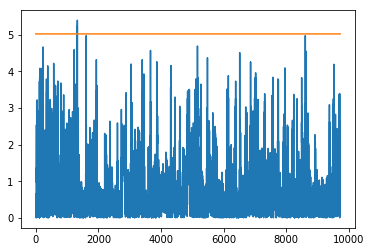

In [32]:
plt.plot([_ for _ in range(len(temp_df.score))], np.abs(temp_df.score))
plt.plot([_ for _ in range(len(temp_df.score))], [thresh for _ in range(len(temp_df.score))])

In [33]:
temp_df["is_abnormal"] = (np.abs(temp_df.score) > thresh).astype(int)

In [34]:
abnorm_idx = temp_df.query("is_abnormal == 1")["index"].astype(int).values

In [35]:
temp_df.query("is_abnormal == 1").head()

,index,diff,score,is_abnormal
1325,1397,-64.857088,-5.235516,1
1327,1399,-66.835519,-5.396924,1


In [36]:
temp_df.tail()

,index,diff,score,is_abnormal
9716,10317,2.413959,0.252721,0
9717,10318,-4.656976,-0.324154,0
9718,10319,-22.400296,-1.771723,0
9719,10320,-4.442298,-0.306639,0
9720,10321,-12.505424,-0.964461,0


In [37]:
abnorm_idx[:10]

array([1397, 1399])

IndexError: index 2 is out of bounds for axis 0 with size 2

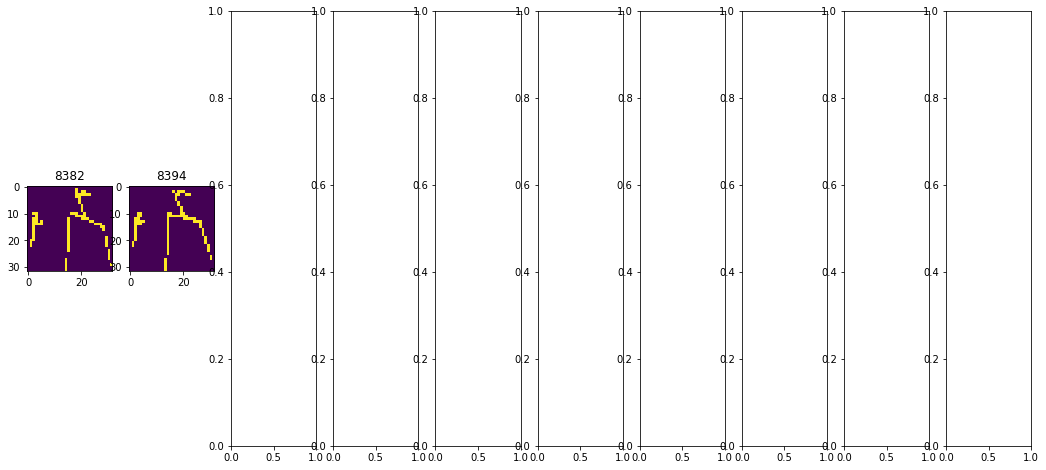

In [38]:
fig, ax = plt.subplots(ncols=10, figsize=(18,8))

for i in range(10):
    ax[i].imshow(imgs[abnorm_idx[i]].reshape(32,32))
    ax[i].set_title("{}".format(abnorm_idx[i]*6))

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(18,8))

for i in range(10):
    ax[i].imshow(img_pred[abnorm_idx[i]].reshape(32,32))
    ax[i].set_title("{}".format(abnorm_idx[i]*6))

## 実際の動画から正しく抽出できているかを見ていく

In [ ]:
int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//6

In [ ]:
def extract(idx, isFujii, cap):
    frames = []
    for i in tqdm(idx, leave=False):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i*6)
        print(i*6)
        frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
        pose_rect = cv2.flip(frame[678:968, 45:565].copy(), 1) if isFujii else frame[220:510, 1340:1860].copy()
        frames.append(pose_rect)
        
    return frames

In [ ]:
cap = cv2.VideoCapture("/media/nvidia/JetsonTX2SSD240/data/AbemaTV_Tournament_Final1.mp4")

In [ ]:
abnorm_idx[-10:] * 6

In [ ]:
frames = extract(abnorm_idx[-10:], False, cap)

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(18,8))

for i in range(10):
    ax[i].imshow(imgs[abnorm_idx[i]].reshape(32,32))
    ax[i].set_title("{}".format(abnorm_idx[-10:][i]*6))

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(30,18))

for i in range(10):
    ax[i].imshow(frames[i])
    ax[i].set_title("{}".format(abnorm_idx[-10:][i]*6))